**Background:**

The purpose of this notebook is to transform the .wav files captured by the SoundFlux team into a set of spectrograms.

In addition, data will be augmented by overlaying different types of backrgound noise

**Note**

As part of the overlay/data augmentation process, only the original classes of falling_dummy and falling_object were kept, in addition to the new 'overlay_noise' class introduced from the augmewntation process

## Libraries and File Locations

In [1]:
import sys
sys.path.append("..")

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
import soundfile
from scipy import signal
import librosa
import matplotlib.pyplot as plt
import specdisplay
from os import listdir
from os.path import isfile, join
import json
from feature_generation import extract_spectrogram
from scipy.io import wavfile
import scipy.signal as sps 

/home/nvidia/github/python_environments/soundflux/lib/python3.5/site-packages/librosa/cache.py:36: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if self.cachedir is not None:
/home/nvidia/github/python_environments/soundflux/lib/python3.5/site-packages/librosa/cache.py:36: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if self.cachedir is not None:
/home/nvidia/github/python_environments/soundflux/lib/python3.5/site-packages/librosa/cache.py:36: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if self.cachedir is not None:
/home/nvidia/github/python_environments/soundflux/lib/python3.5/

/home/nvidia/github/python_environments/soundflux/lib/python3.5/site-packages/librosa/cache.py:36: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if self.cachedir is not None:
/home/nvidia/github/python_environments/soundflux/lib/python3.5/site-packages/librosa/cache.py:36: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if self.cachedir is not None:
/home/nvidia/github/python_environments/soundflux/lib/python3.5/site-packages/librosa/cache.py:36: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if self.cachedir is not None:
/home/nvidia/github/python_environments/soundflux/lib/python3.5/

In [3]:
import random
random.seed(7)

## Define file generation parameters

**Number of Mel-frequencies to keep in the spectrograms**

In [4]:
n_mels = 128

**Files we'll do overlay with, and relevant parameters**

In [5]:
#amplitude of overlay as a percentage of the fall
power_scale_overlay = 0.2 

In [6]:
overlay_file_mapping = {'running_shower' : 'resampled_169659_shower.wav',
               'children_playing' : 'resampled_children_ambiance.wav',
               'group_talk':'resampled_group_talking.wav',
               'white_noise_med_pitch':'resampled_white_noise_med_pitch.wav',
               'white_noise_low_pitch':'resampled_white_noise_low_pitch.wav',
               'background_music':'resampled_random_hip_hop.wav'}

In [7]:
#number of randomly selected overlays per file
overlays_per_overlay_file=5

In [8]:
def get_overlay_scaler(normal_file, overlay_file,power_scale_overlay=0.2):
    max_normal = max(np.max(normal_file),-np.min(normal_file))
    max_overlay = max(np.max(overlay_file),-np.min(overlay_file))
    scale_factor = (max_normal*power_scale_overlay)/ max_overlay
    return scale_factor

In [9]:
def get_random_section_of_x_length(overlay_data, size):
    starting_points = (overlay_data.shape[0]-size)
    start = random.choice(range(0,starting_points+1))
    subset = overlay_data[start:start+size]
    return subset

# Creating the PNG spectrograms

Target folder where pull the original soundflux audio files from

In [10]:
samples_folder = "/home/nvidia/github/soundflux/samples"

# Read all of the json files

In [11]:
metadata = [samples_folder+"/"+ f for f in listdir(samples_folder) if isfile(join(samples_folder, f)) and ".json" in f]

In [12]:
data = []
error_count = 0
for fi in metadata:
    log = open(fi, "r").read()
    try:
        d = json.loads(log)
        if isinstance(d,dict):
            data.append(d)
    except Exception as e:
        error_count +=1
        print("Error number {}".format(error_count))

Error number 1


In [13]:
len(data)

482

In [14]:
dataset = pd.DataFrame(data)

In [15]:
target_folder = "/home/nvidia/Downloads/soundflux_augmented"

## Write to spectrograms

In [16]:
split=True
test_split = 0.20

In [17]:
def create_and_save_spectrogram(y,sr,target_file):
    #new plot
    log_s = extract_spectrogram(y,sr,n_mels=n_mels,n_fft=2048)
    fig = plt.figure(figsize=(12,4))
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)

    #getting spectrogram
    specdisplay.specshow(log_s, sr=sr, x_axis='time', y_axis='mel')

    #Saving PNG
    plt.savefig(target_file)
    plt.close()

Transforming file 151
Transforming file 152


KeyboardInterrupt: 

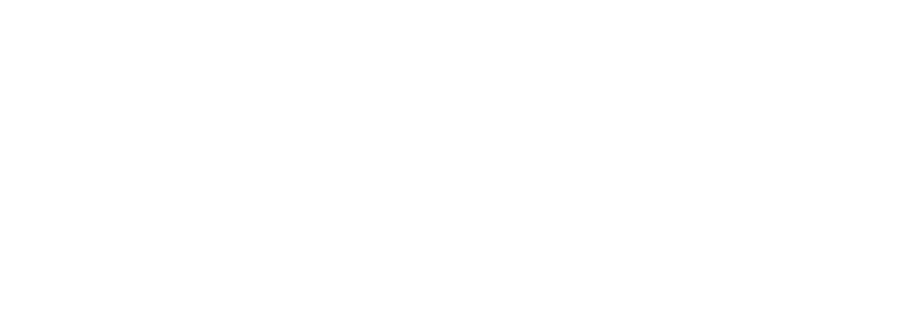

In [20]:
for index, row in dataset[151:199:199].iterrows():
    print("Transforming file {}".format(index))
    if not os.path.exists(target_folder + "/"+'spectrograms'):
        os.makedirs(target_folder + "/"+'spectrograms')
    file_folder = str(target_folder+ "/"+'spectrograms')
    if split:
        if not os.path.exists(file_folder+ "/"+'split'):
            os.makedirs(file_folder + "/"+'split')
        #30% on testing
        split_folder =file_folder+ "/"+'split'
        if not os.path.exists(split_folder+ "/"+'train'):
            os.makedirs(split_folder +"/"+'train')
        if not os.path.exists(split_folder+ "/"+'test'):
            os.makedirs(split_folder+ "/"+'test')
        if random.randint(0,99) < test_split*100:
            file_folder = split_folder + '/test'
        else:
            file_folder = split_folder + '/train'
        
        
        
    if not os.path.exists(file_folder + "/" + row['class']):
        os.makedirs(file_folder + "/" + row['class'])
    if not os.path.exists(file_folder + "/overlay_noise"):
        os.makedirs(file_folder + "/overlay_noise")

    # Convert to log scale (dB). We'll use the peak power as reference.
    y, sr = soundfile.read(samples_folder + "/"+ str(row['audio_file']))
    target_file_name = file_folder + '/' + row['class'] + '/' + row['id'] + '.png'
    #save original spectrogram
    create_and_save_spectrogram(y,sr,target_file_name)
    #pick one channel from the recorded sample:
    for k,v in overlay_file_mapping.items():
        y_mono = np.squeeze(y[:,:1])
        overlay_data, overlay_sampling_rate = soundfile.read("./overlay_files/{}".format(v))
        if overlay_sampling_rate != sr:
            #assumes sr is greater
            rate = int(sr/overlay_sampling_rate)
            y_mono_base = sps.decimate(y_mono,3)
        else:
            y_mono_base = y_mono
        for idx in range(0,overlays_per_overlay_file):
            random_overlay = get_random_section_of_x_length(overlay_data, y_mono_base.shape[0])
            scale_factor = get_overlay_scaler(y_mono_base,random_overlay,power_scale_overlay)
            final_overlayed_data = np.add(y_mono_base,scale_factor*random_overlay)
            #write to temp and read again, otherwise data is messed up
            temp_overlay_wav_file = "temp_overlay.wav"
            wavfile.write(temp_overlay_wav_file, overlay_sampling_rate, final_overlayed_data.T)
            #read and generate spectrogram
            combined_sound, combined_sample_rate = soundfile.read(temp_overlay_wav_file)
            overlayed_target_file_name = file_folder + '/' + row['class'] + '/' + row['id'] + '_{}_{}_overlay.png'.format(k,idx)
            create_and_save_spectrogram(combined_sound,combined_sample_rate,overlayed_target_file_name)
            #save original overlay too!
            overlay_target_file_name = file_folder + '/' + "overlay_noise" + '/' + row['id'] + '{}_{}_overlay_only.png'.format(k,idx)
            create_and_save_spectrogram(random_overlay,overlay_sampling_rate,overlay_target_file_name)